In [1]:
import timeit
from tqdm import tqdm
import re
import sympy as sp
import vector
import math
import numpy as np
import awkward as ak
import uproot as ut
import git
import sys
import os
%load_ext autoreload
%autoreload 2


sys.path.append(git.Repo('.', search_parent_directories=True).working_tree_dir)
from utils import *

In [2]:
fname = "/eos/uscms/store/user/ekoenig/6BAnalysis/NTuples/2018/SR/NN_Higgs/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400_10M/output/ntuple_{nf}.root"
train_tree = Tree(fname.format(nf=0))
test_tree = Tree(fname.format(nf=9))
treeiter = TreeIter([train_tree,test_tree])


In [3]:
treeiter.extend(kwargs=lambda tree : dict(
    Ht = ak.sum(tree.jet_pt,axis=-1),
    ptD = ak.sum(tree.jet_pt**2,axis=-1)/ak.sum(tree.jet_pt,axis=-1),
    jet_qgl = ak.where( np.isnan(tree.jet_qgl),-1,tree.jet_qgl ),
    **calc_thrust(tree.jet_pt,tree.jet_eta,tree.jet_phi,tree.jet_m)
))

treeiter.extend(kwargs=lambda tree : dict(
    jet_ptfrac= tree.jet_pt/tree.Ht,
    jet_ptDfrac=tree.jet_pt/tree.ptD,
    jet_thrustDev = calc_dphi(tree.thrust_phi,tree.jet_phi)
))

[None, None]

In [4]:
jets = get_collection(train_tree,'jet',named=False)
fields = jets.fields
fields

['E',
 'm',
 'pt',
 'eta',
 'phi',
 'btag',
 'qgl',
 'chEmEF',
 'chHEF',
 'neEmEF',
 'neHEF',
 'nCons',
 'nEle',
 'nMu',
 'id',
 'puid',
 'signalId',
 'higgsIdx',
 'genIdx',
 'preselIdx',
 'ptfrac',
 'ptDfrac',
 'thrustDev']

# Prep Features


In [5]:
lstm6j.feature_names = ['E','m','pt','ptfrac','ptDfrac','eta','phi','thrustDev','btag','qgl','chEmEF','chHEF','neEmEF','neHEF','nCons','nEle','nMu']

In [6]:
train_features,train_target = lstm6j.tree_features_target(train_tree)
test_features,test_target = lstm6j.tree_features_target(test_tree)

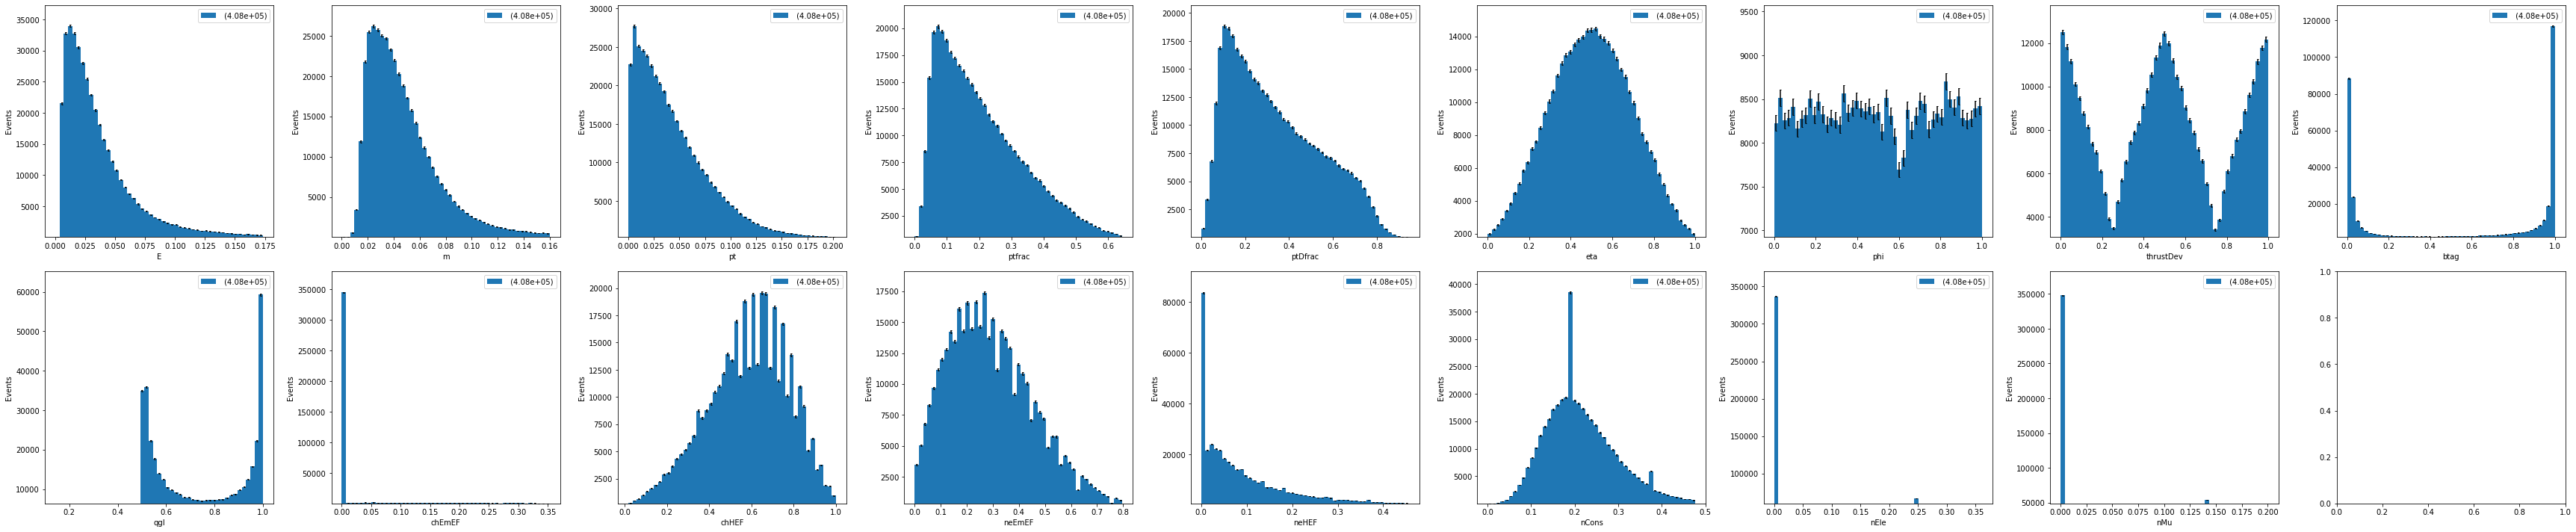

In [7]:
fig = plot_features(train_features)

In [8]:
r_X_train, y_train, maxjets, nfeatures, maskint = lstm6j.reshape_features(train_features,train_target.is_signal)
r_X_test, y_test, maxjets, nfeatures, maskint = lstm6j.reshape_features(test_features,test_target.is_signal, maxjets=maxjets,maskint=maskint)
maxjets,nfeatures

(15, 17)

# Build NN


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score


In [10]:
model = keras.models.Sequential()

model.add(layers.Masking(mask_value=maskint, input_shape=(None, nfeatures)))
model.add(layers.Bidirectional(layers.LSTM(240, activation='relu', return_sequences=True)))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 17)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 480)         495360    
_________________________________________________________________
dense (Dense)                (None, None, 120)         57720     
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           242       
Total params: 553,322
Trainable params: 553,322
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [12]:
history = model.fit(
    r_X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=250,
    verbose=1
)


Epoch 1/5
202/202 [==============================] - 50s 228ms/step - loss: 0.1826 - accuracy: 0.8405 - val_loss: 0.1524 - val_accuracy: 0.8780
Epoch 2/5
202/202 [==============================] - 45s 224ms/step - loss: 0.1492 - accuracy: 0.8816 - val_loss: 0.1440 - val_accuracy: 0.8863
Epoch 3/5
202/202 [==============================] - 44s 217ms/step - loss: 0.1424 - accuracy: 0.8875 - val_loss: 0.1402 - val_accuracy: 0.8899
Epoch 4/5
202/202 [==============================] - 43s 215ms/step - loss: 0.1393 - accuracy: 0.8902 - val_loss: 0.1381 - val_accuracy: 0.8914
Epoch 5/5
202/202 [==============================] - 41s 202ms/step - loss: 0.1378 - accuracy: 0.8915 - val_loss: 0.1373 - val_accuracy: 0.8920


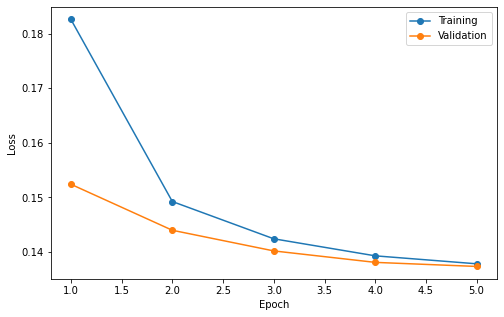

In [13]:
fig,ax = plot_history(history,'loss')

# study.save_fig(fig,'','rnn-loss')

In [14]:
y_pred = model.predict(r_X_test)

In [15]:
y_ak,y_pred_ak = lstm6j.jet_reshape(y_test,y_pred,maskint)

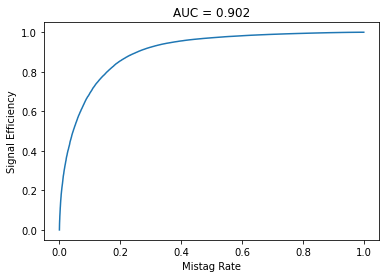

In [16]:
fpr, tpr, thresholds = lstm6j.plot_roc(y_ak,y_pred_ak)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='NN Score', ylabel='Fraction of Events'>)

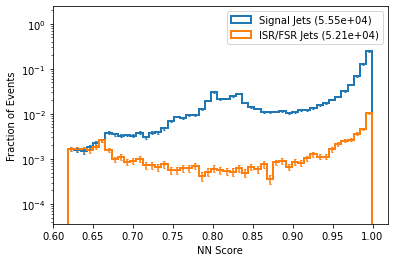

In [17]:
sig_scores = ak.mean(y_pred_ak[(y_ak == 1)],axis=-1)
bkg_scores = ak.mean(y_pred_ak[(y_ak == 0)],axis=-1)

hist_multi([sig_scores,bkg_scores],labels=["Signal Jets","ISR/FSR Jets"],xlabel="NN Score",log=1,density=1)

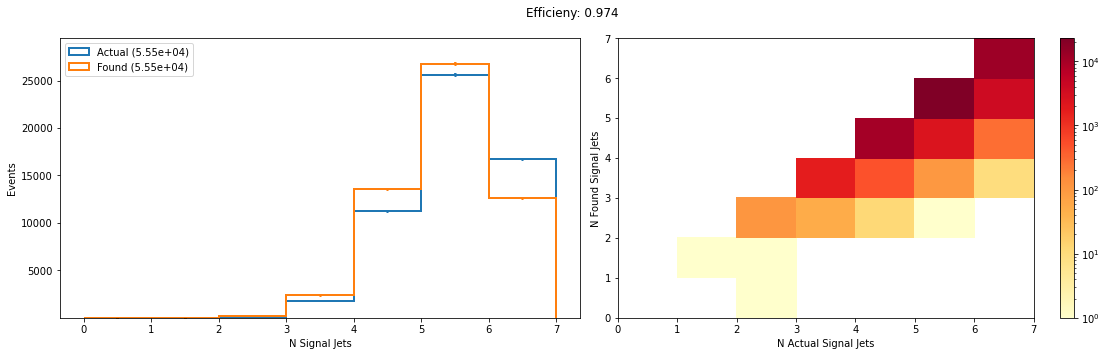

In [18]:
nsig = ak.sum(y_ak,axis=-1)
nsig_pred = ak.sum(y_ak[ak.argsort(-y_pred_ak,axis=-1)[:,:6]],axis=-1)
fig = plot_efficiency(nsig_pred,nsig)
# study.save_fig(fig,'',saveas='rnn-eff')

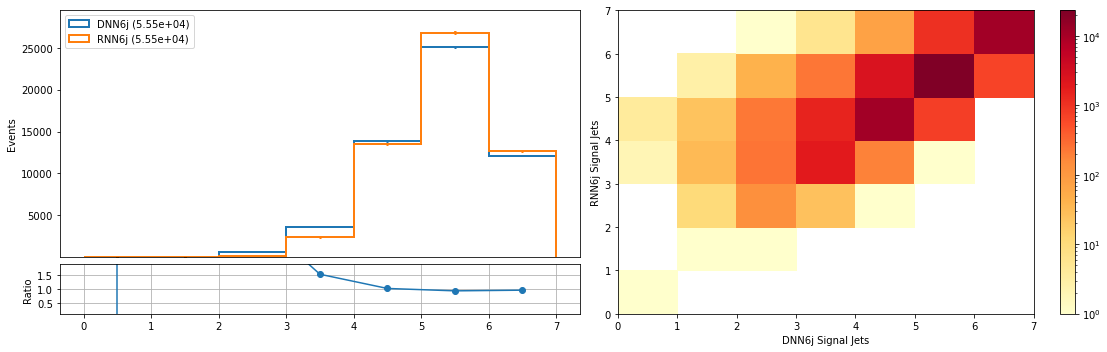

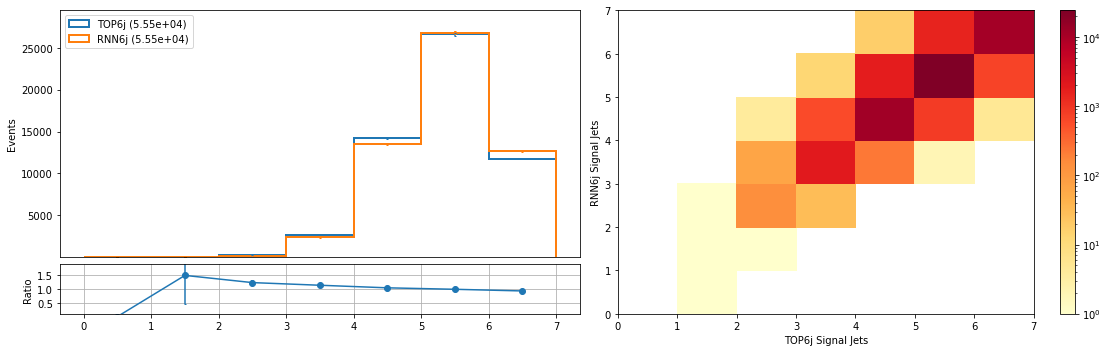

In [19]:
compare_methods(test_tree.nfound_nn,nsig_pred,'DNN6j','RNN6j');
compare_methods(test_tree.nfound_t6,nsig_pred,'TOP6j','RNN6j');
# study.save_fig(fig,'','rnn-dnn')